----------

## <span style="color:red">Комментарий от наставника</span>

Привет! Спасибо, что сдал задание:) Ты проделал большую работу. Далее в файле мои комментарии ты сможешь найти в подобных ячейках. Пострайся учесть эти комментарии в ходе выполнения дальнейших проектов.

Обрати внимание, для твоего удобства я буду выделять свои комментарии цветом, в зависимости от того, какая это итерация проверки:

1. ## <span style="color:red">Комментарий от наставника (1я итерация)</span>
2. ## <span style="color:orange">Комментарий от наставника (следующие итерации кроме финальной)</span>
3. ## <span style="color:purple">Комментарий от наставника (финальная итерация)</span>

Комментарии, по которым ты провел работу и внес изменения, я буду помечать <span style="color:green;font-size:200%">&#10003;</span>

#### Общие рекомендации к работе, на которых я не буду больше останавливаться:
1. В начале работы кратко опиши цели исследования и данные, с которыми работаешь.
2. Добавь содержание в __markdown-ячейке__ и следуй ему. Можешь даже сделать <a href="https://sebastianraschka.com/Articles/2014_ipython_internal_links.html">кликабельные разделы</a>, чтобы ориентироваться в проекте было еще проще
3. Делай комментарии в коде, если это необходимо
```python
# комментарий
import pandas as pd
import numpy as np
```
4. Добавляй __докстринги__ к функциям
```python
def handle_age(age):
    """
    Функция для обработки некорректного возраста в столбце age
    """
    ...
    return age
```
5. Делай понятные названия переменных, например вместо __dct__ лучше назвать переменную __purpose_dict__
6. Убедись, что у ноутбуке нет ничего лишнего - закомментированного кода, временных ячеек
7. __Перед отправкой проекта Наставнику выполни все ячейки в jupyter-ноутбуке и убедись, что код во всех ячейках выполнен без ошибок__

---------

# Содержание:
* [Подготовка данных](#first-bullet)
* [Часть 1. Приоритезация гипотез](#second-bullet)
* [Часть 2. Анализ A/B-теста](#third-bullet)

## Подготовка данных<a class="anchor" id="first-bullet"></a>

In [1]:
# блок импорта библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns

import timeit
pd.options.display.max_colwidth = 120

In [2]:
df1 = pd.read_csv('/datasets/hypothesis.csv')
df2 = pd.read_csv('/datasets/orders.csv')
df3 = pd.read_csv('/datasets/visitors.csv')

hypothesis = df1.copy()
orders = df2.copy()
visitors = df3.copy()

In [3]:
def my_info(data):
    """
    Более информативная версия .info().
    Использует более рационально место в jupiter, в дополнение к информации info выводит:
    количество нулей, уникальные значения, типы, наиболее частые значения (само значение и частота),
    среднее использование памяти.
    
    """
    columns = ['non-null', 'null', 'unique', 'type', 'top', 'freq', 'mean_memory_usage']
    index = []
    result = []
    for col in data.columns:
        # calculate memory
        serias_type = data[col].dtype
        selected_dtype = data.select_dtypes(include=[serias_type])
        mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
        # returns size in human readable format
        def sizeof_fmt(num):
            # returns size in human readable format
            for x in ["bytes", "KB", "MB", "GB", "TB"]:
                if num < 1024.0:
                    return "{num:3.1f} {x}".format(num=num, x=x)
                num /= 1024.0
            return "{num:3.1f} {pb}".format(num=num, pb="PB")
        
        mean_memory = sizeof_fmt(mean_usage_b)
        
        objcounts = data[col].value_counts() # count unique
        index.append(col)                  # add columns
        result.append(
            [len(data[data[col].notna()]), # non-null
            len(data[data[col].isna()]),   # null
            len(data[col].unique()),       # unique
            serias_type,               # type
            objcounts.index[0],            # top
            objcounts.iloc[0],
            mean_memory])            # freq

    result = pd.DataFrame(result, index=index, columns=columns)
    return result

In [4]:
my_info(hypothesis)

,non-null,null,unique,type,top,freq,mean_memory_usage
Hypothesis,9,0,9,object,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",1,1.2 KB
Reach,9,0,6,int64,3,3,73.6 bytes
Impact,9,0,7,int64,3,3,73.6 bytes
Confidence,9,0,7,int64,8,3,73.6 bytes
Efforts,9,0,6,int64,3,3,73.6 bytes


In [5]:
my_info(orders)

,non-null,null,unique,type,top,freq,mean_memory_usage
transactionId,1197,0,1197,int64,3574407166,1,7.0 KB
visitorId,1197,0,1031,int64,4256040402,11,7.0 KB
date,1197,0,31,object,2019-08-05,48,51.8 KB
revenue,1197,0,713,int64,990,17,7.0 KB
group,1197,0,2,object,B,640,51.8 KB


In [6]:
my_info(visitors)

,non-null,null,unique,type,top,freq,mean_memory_usage
date,62,0,31,object,2019-08-09,2,2.7 KB
group,62,0,2,object,B,31,2.7 KB
visitors,62,0,58,int64,610,2,288.0 bytes


In [7]:
# перевести строчную дату в формат даты
orders['date'] = pd.to_datetime(orders['date'], format="%Y-%m-%d")
visitors['date'] = pd.to_datetime(visitors['date'], format="%Y-%m-%d")

## Часть 1. Приоритезация гипотез <a class="anchor" id="second-bullet"></a>

In [8]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


#### Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

In [9]:
hypothesis['ICE'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
hypothesis[['Hypothesis','ICE']].sort_values(by='ICE', ascending=False)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


#### Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

In [10]:
hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
hypothesis[['Hypothesis','RICE']].sort_values(by='RICE', ascending=False)

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


#### Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

Для того, чтобы оценить как изменились метрики при применении RICE вместо ICE, построим матрицу Эйзенхауэра:

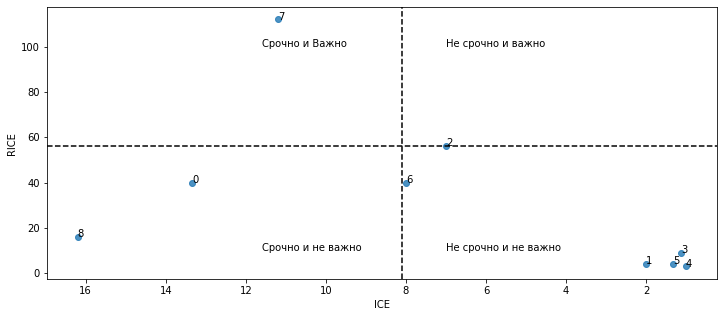

In [11]:
# добавить новый столбец с индексом
hypothesis['id'] = hypothesis.index
# отрисовать график
fig, ax = plt.subplots(figsize = (12, 5))
text1 = plt.text(7, 10, 'Не срочно и не важно')
text1 = plt.text(11.6, 10, 'Срочно и не важно')
text1 = plt.text(7, 100, 'Не срочно и важно')
text1 = plt.text(11.6, 100, 'Срочно и Важно')
ax.scatter(hypothesis['ICE'], hypothesis['RICE'], alpha=0.8)
# разделить матрицу пополам
plt.axvline(x=(hypothesis['ICE'].max() / 2), color='black', linestyle='--')
plt.axhline(y=(hypothesis['RICE'].max() / 2), color='black', linestyle='--')
# подписать оси матрицы
plt.xlabel('ICE')
plt.ylabel('RICE')
# развернуть ось х наоборот
plt.gca().invert_xaxis()
# присвоить точкам индексы
for i, txt in enumerate(hypothesis['id']):
    ax.annotate(txt, (hypothesis['ICE'][i], hypothesis['RICE'][i]))  

Используя только фреймфорк ICE мы бы переоценили важность гипотез 8 (Запустить акцию, дающую скидку на товар в день рождения) и 0 (Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей), за счет того, что компонента фреймворка Impact, для этих гипотез, имеет одну из самых высоких оценок, однако вводя переменную Reach, при использовании RICE мы получаем, что мероприятия по данным гипотезам у нас затронут малое количество пользователей.  

Таким образом, по матрице Эйзенхауэра получаем приоритет гипотез 7 (Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок), 2 (Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа), 0 (Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей), 6 (Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию). Получается ТОП 4 позиции RICE стали приоритетом.

## Часть 2. Анализ A/B-теста <a class="anchor" id="third-bullet"></a>

In [12]:
# посмотреть на содержимое дф
display(orders.head(), visitors.head())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


#### Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения:

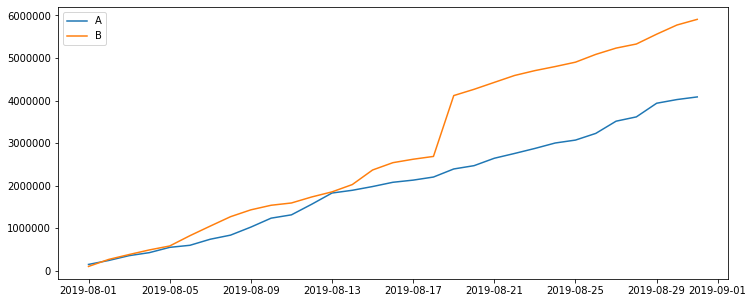

In [13]:
# создать список уникальных дат и групп из orders
datesGroups = orders[['date','group']].drop_duplicates()
# сгруппировать по дате и группе, суммируя накопительным итогом по предыдущим датам, получая кумммулятивный "эффект" 
# альтернативный код выглядел бы так:
# orders_group_A = orders[orders['group'] == 'A'].drop('group', axis=1).groupby('date').agg({
#                    'transactionId' : pd.Series.nunique,
#                    'visitorId' : pd.Series.nunique,
#                    'revenue' : 'sum'}).sort_values(by=['date'])
# orders_group['revenue'] = orders_group['revenue'].cumsum()
#
ordersAgg = datesGroups.apply(
                    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
                    'date' : 'max',
                    'group' : 'max',
                    'transactionId' : pd.Series.nunique,
                    'visitorId' : pd.Series.nunique,
                    'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

visitorsAgg = datesGroups.apply(
                    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
                    'date' : 'max',
                    'group' : 'max',
                    'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])
# объединить результаты агрегации и переименовать столбцы
cummData = ordersAgg.merge(visitorsAgg, left_on=['date', 'group'], right_on=['date', 'group'])
cummData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# отсортировать группы
cummRevenueA = cummData[cummData['group']=='A'][['date', 'revenue', 'orders']]
cummRevenueB = cummData[cummData['group']=='B'][['date', 'revenue', 'orders']]
# отрисовать графики по группам
pd.plotting.register_matplotlib_converters()
fig = plt.figure(figsize = (12, 5))
plt.plot(cummRevenueA['date'], cummRevenueA['revenue'], label='A')
plt.plot(cummRevenueB['date'], cummRevenueB['revenue'], label='B')

plt.legend()

Выручка почти равномерно увеличивается в течение всего теста.Однако график B имеет резкий скачек это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

#### Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения:


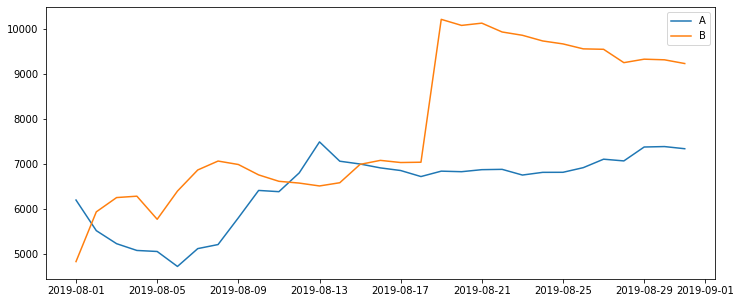

In [14]:
fig = plt.figure(figsize = (12, 5))
plt.plot(cummRevenueA['date'], cummRevenueA['revenue'] / cummRevenueA['orders'], label='A')
plt.plot(cummRevenueB['date'], cummRevenueB['revenue'] / cummRevenueB['orders'], label='B')
plt.legend()

Кумулятивное значение среднего чека сегмента B имеет ярко выраженный скачек, после скачка имеет тенденцию к снижению. Кумулятивное значение среднего чека сегманта А имело мощный рост с 5 по 13 число, и становится равномерным ближе к концу теста. Скорее всего, принимать решение по этой метрике рано, требуется дополнительный анализ выбросов, которые так сильно искажают результаты.

#### Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения:


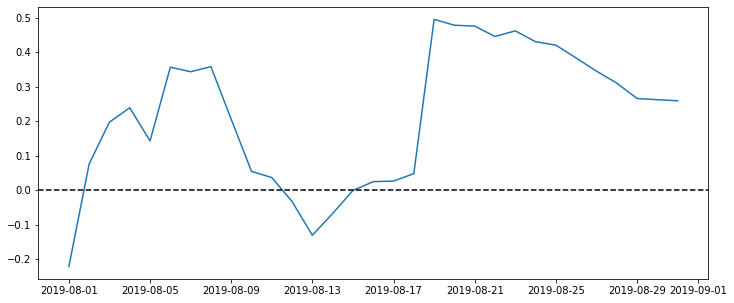

In [15]:
# собрать данные в одном датафрейме
mergedCummRevenue = cummRevenueA.merge(cummRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# поcтроить отношение средних чеков
fig = plt.figure(figsize = (12, 5))
plt.plot(mergedCummRevenue['date'], (mergedCummRevenue['revenueB']/mergedCummRevenue['ordersB'])/(mergedCummRevenue['revenueA']/mergedCummRevenue['ordersA'])-1)

# добавить ось X
plt.axhline(y=0, color='black', linestyle='--')

В нескольких точках график различия между сегментами резко «скачет» скорре всего это крупные заказы и выбросы.

#### Постройте график кумулятивной конверсии по группам. Сделайте выводы и предположения:


['2019-08-01', '2019-09-01', 0.02, 0.05]

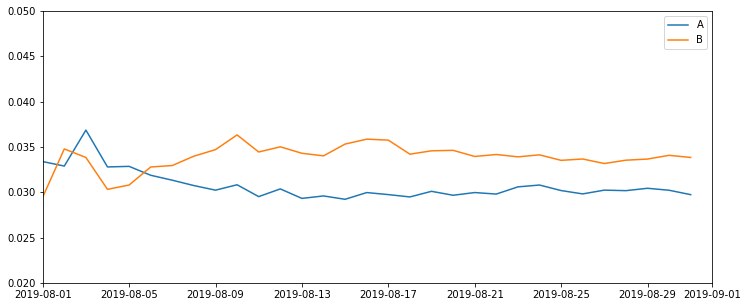

In [16]:
# Посчитать кумулятивную конверсию
cummData['conversion'] = cummData['orders'] / cummData['visitors']

# Отделить данные по группе A
cummDataA = cummData[cummData['group']=='A']

# Отделить данные по группе B
cummDataB = cummData[cummData['group']=='B']

# Построить графики
fig = plt.figure(figsize = (12, 5))
plt.plot(cummDataA['date'], cummDataA['conversion'], label='A')
plt.plot(cummDataB['date'], cummDataB['conversion'], label='B')
plt.legend()
plt.axis(['2019-08-01', '2019-09-01', 0.02, 0.05])

Получился ассиметричный график, с некоторым лагом группы противополжны друг другу. Сначала сегмент А имел большую конверсию, однако после 9 дней теста скатился на 0,7% в то время как сегмент В в этот момент эти 0,7 процентов набрал. Последние 13 дней конверсия групп стабилизировалась и остановилась на отметках 0,030 и 0,034 для групп А и Б соотвестенно.

#### Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения:


['2019-08-01', '2019-09-01', -0.12, 0.22]

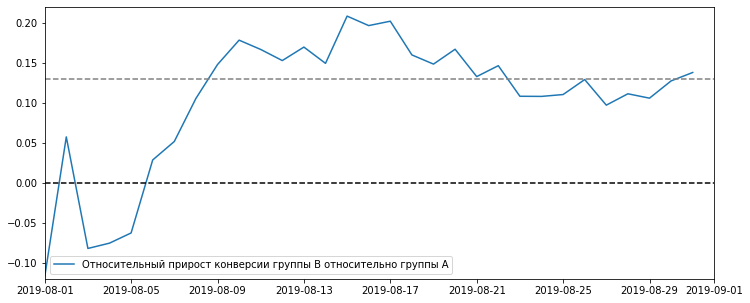

In [17]:
mergedCummConvers = (cummDataA[['date','conversion']]
                     .merge(cummDataB[['date','conversion']], 
                            left_on='date', 
                            right_on='date', 
                            how='left', 
                            suffixes=['A', 'B']))

fig = plt.figure(figsize = (12, 5))
plt.plot(mergedCummConvers['date'], 
         mergedCummConvers['conversionB'] / mergedCummConvers['conversionA']-1, 
         label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.13, color='grey', linestyle='--')
plt.axis(['2019-08-01', '2019-09-01', -0.12, 0.22])

Сначача первые пару дней конверсия группы В падала относительно группы А, после, группа В показала мощный рост конверсии, поднявшись на 27%, став больше конверсии А на 20 %, к концу теста конверсия группы В стабильно выше на 13 % группы А.

#### Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения:


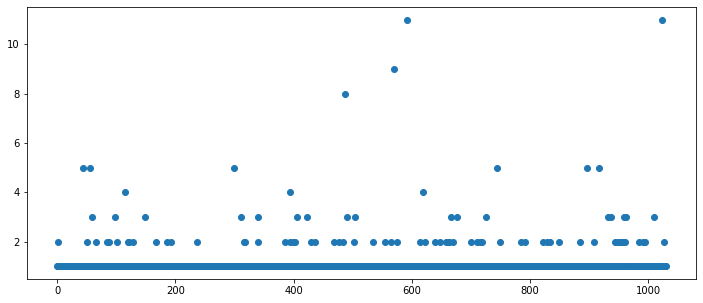

In [18]:
ordersByUsers = (orders[['transactionId', 'visitorId']]
                 .groupby('visitorId', as_index=False)
                 .agg({'transactionId' : pd.Series.nunique}))

ordersByUsers.columns = ['visitorId','orders']

x_values = pd.Series(range(0,len(ordersByUsers)))
fig = plt.figure(figsize = (12, 5))
plt.scatter(x_values, ordersByUsers['orders'])

Пользователей сделавших 2-4 заказа много, что бы считать их аномалиями или не необходимо посчитать выборочные перцентили.

#### Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей:

In [19]:
print(np.percentile(ordersByUsers['orders'],[ 95, 99]))

[2. 4.]


Не более 5 % совершали два заказа, и не более 1% совершали 4 заказа.

#### Постройте точечный график стоимостей заказов. Сделайте выводы и предположения:


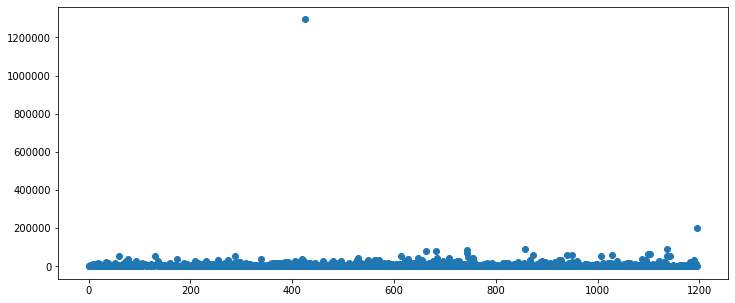

In [20]:
x_values = pd.Series(range(0,len(orders)))
fig = plt.figure(figsize = (12, 5))
plt.scatter(x_values, orders['revenue'])

Есть выборсы за 1200000, остальные заказы сложно оценить из-за масштаба графика, оценим через перцентили.

#### Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов:


In [21]:
print(np.percentile(orders['revenue'],[ 95, 99]))

[28000.  58233.2]


Не более 5 % совершали заказ на 28000, и не более 1% совершали заказ на 58233.

#### Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным. Сделайте выводы и предположения:

In [22]:
alpha = .05 # критический уровень статистической значимости

results = st.mannwhitneyu(cummDataA['conversion'], cummDataB['conversion'])

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

p-значение:  1.2368310681408489e-08
Отвергаем нулевую гипотезу: разница статистически значима


Конверсия группы В больше конверсии группы А, это было определено графическим методом, а сейчас подтверждено статистически. Учтывая, что U-критерий Манна-Уитни устойчив к выбросам, вполне может быть, что конверсия группы В просто больше, как бы мы не очищали данные, но проверим это позже.

#### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения:


In [23]:
alpha = .05 # критический уровень статистической значимости

results = st.mannwhitneyu(cummRevenueA['revenue'] / cummRevenueA['orders'], cummRevenueB['revenue'] / cummRevenueB['orders'])

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

p-значение:  0.004235540740704507
Отвергаем нулевую гипотезу: разница статистически значима


Средний чек группы В больше среднего чека группы А, это было определено графическим методом, однако мы имели сильный "бросок" графика, что задрудняло корректную оцнеку, но сейчас это подтверждено статистически.

#### Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделайте выводы и предположения:


Очищать будем по количеству заказов (свыше 4) и выручку с заказа свыше 58233

In [24]:
# сгруппировать пользователей и количество заказов
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']
# сформировать "черный список выбросов"
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 4]['userId'], 
                                 ordersByUsersB[ordersByUsersB['orders'] > 4]['userId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 58233]['visitorId']
usersWithExpensiveOrders.name = 'userId'


In [25]:
# объединить "черный список выбросов"
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()

# если пользователь не замечен в "черном списке", оставить его заказы в выборке
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],
                             pd.Series(0, index=np.arange(cummDataA['visitors'].sum() - len(ordersByUsersA['orders'])), 
                                       name='orders')], axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],
                             pd.Series(0, index=np.arange(cummDataB['visitors'].sum() - len(ordersByUsersB['orders'])),
                                       name='orders')],axis=0)

In [26]:
alpha = .05 # критический уровень статистической значимости

results = st.mannwhitneyu(sampleAFiltered, sampleBFiltered)

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

p-значение:  0.006266409556299852
Отвергаем нулевую гипотезу: разница статистически значима


Удаление выбросов, не дало результатов, как предполагалось, конверсия группы В выше.

#### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения:


In [27]:
# если пользователь не замечен в "черном списке", оставитьвыручку с его заказов в выборке
FilteredRevenueA = (orders[np.logical_and(orders['group']=='A', 
                                          np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])

FilteredRevenueB = (orders[np.logical_and(orders['group']=='B', 
                                          np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])


In [28]:
alpha = .05 # критический уровень статистической значимости

results = st.mannwhitneyu(FilteredRevenueA, FilteredRevenueB)

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

p-значение:  0.42545630956909697
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


А вот здесь нас ждал сюрприз, выбросы все таки обманули наш тест, теперь же, после очистки данных, мы получили, что средний чек не различается.

#### Примите решение по результатам теста и объясните его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.

Не смотря на то, что средний чек не различается, пользователи группы В делают больше заказов, что приносит компании больше выручки, исходя из этого, я считаю, что тестирование закончено, группа В победила в данном исследовании.
Для подтверждеия визуально, построим график выручки для очищенных данных.

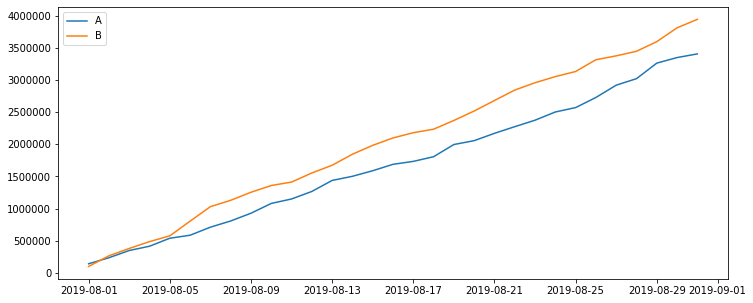

In [29]:
clean_orders = orders[np.logical_not(orders['visitorId'].isin(abnormalUsers))]
# сгруппировать по дате и группе, суммируя накопительным итогоb по предыдущим датам, получая кумммулятивный "эффект" 
ordersAgg = datesGroups.apply(
                    lambda x: clean_orders[np.logical_and(clean_orders['date'] <= x['date'], 
                                                          clean_orders['group'] == x['group'])].agg({
                    'date' : 'max',
                    'group' : 'max',
                    'transactionId' : pd.Series.nunique,
                    'visitorId' : pd.Series.nunique,
                    'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

visitorsAgg = datesGroups.apply(
                    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
                    'date' : 'max',
                    'group' : 'max',
                    'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])
# объединить результаты агрегации и переименовать столбцы
cummData = ordersAgg.merge(visitorsAgg, left_on=['date', 'group'], right_on=['date', 'group'])
cummData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# отсортировать группы
cummRevenueA = cummData[cummData['group']=='A'][['date', 'revenue', 'orders']]
cummRevenueB = cummData[cummData['group']=='B'][['date', 'revenue', 'orders']]
# отрисовать графики по группам
fig = plt.figure(figsize = (12, 5))
plt.plot(cummRevenueA['date'], cummRevenueA['revenue'], label='A')
plt.plot(cummRevenueB['date'], cummRevenueB['revenue'], label='B')

plt.legend()

Как видно из графика по очищенным данным выручка группы В практически с первых дней начинает обгонять выручку группы А, благодаря более высокой конверсии.